## Open AI Gym - Scratch Pad

**Basic Environment methods:**
* reset(self): Reset and returns observation.
* step(self, action): run one time steps and returns observation, reward, done, info
* render(self, mode='human', close=False): render one frame (*mode E {'human','rgb_array','ansi'}*)

**Check Spaces**
* Action space: env.action_space
* Observation space: env.observation_space

** Check Environemnts**
* Check all available environments: gym.envs.registry.env_specs or gym.envs.registry.all()
* CartPole v0 State Representation:  [Cart Position, Cart Velocity, Pole Angle, Pole Velocity at Tip] [Cart Pole Wiki](https://github.com/openai/gym/wiki/CartPole-v0)
* Pendulum V0 observation and actions space specs: [Pendulum Wiki](https://github.com/openai/gym/wiki/Pendulum-v0)

* try better way to automatically construct tf.case DICTIONARY
* create head specific name space
* ow to check that for giben task only one HEAD is being updated

https://stackoverflow.com/questions/35678883/tensorflow-getting-variable-by-name

- penalize instead of reward for touching grounds with legs

y = 27.61266 - 2.581069e-15*x - 103.0681*x^2
y = 27.61266 - 6.018842e-14*x - 103.0681*x^2 + 6.702331e-14*x^3

y = -5.684342e-14 + 1.088078e-13*x + 177.7778*x^2 - 1.214129e-13*x^3 - 277.7778*x^4

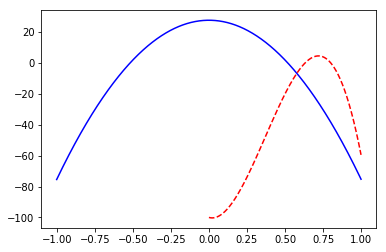

In [110]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

x_1 = np.arange(-1,1,0.001)
x_2 = np.arange(0,1,0.001)
x_penalty = + 27.61266 - 2.581069e-15*x_1 - 103.0681*x_1**2
x_penalty_2 = - 100 - 28.33333*x_2 + 685*x_2**2 - 616.6667*x_2**3
plt.plot(x_1, x_penalty, 'b-',x_2, x_penalty_2, 'r--')

In [19]:
import gym
%load_ext autoreload
%autoreload
env = gym.make("LunarLander-v2")
# env = gym.make("LunarLanderMod-v2")


# env = gym.make("LunarLanderContinuous-v2")
# env = gym.make("BipedalWalker-v2")
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make("CarRacing-v0")
# env = gym.make("LunarLanderContinuous-v2")
# env = gym.make("Pendulum-v0")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


AttributeError: 'Discrete' object has no attribute 'low'

In [15]:
# %load_ext autoreload
%autoreload

num_episodes = 1
num_time_steps = 200

# chunk = 5
# chunk_x1 = env.env.sky_polys[chunk-1][0][0]
# chunk_x2 = env.env.sky_polys[chunk][1][0]
# chunk_y1 = env.env.sky_polys[chunk-1][0][1]
# chunk_y2 = env.env.sky_polys[chunk][1][1]

for episode in range(num_episodes):
#     print("\nEpisode No.: {}".format(episode))
    env.env.seed(12) # Set seed before reseting env to allow repeatability
    observation = env.reset()
#     env.env.helipad_x1 = chunk_x1
#     env.env.helipad_x2 = chunk_x2
#     env.env.helipad_y = min(chunk_y1, chunk_y2)
    
    for t in range(num_time_steps):
        print(observation)
        env.render()
        action = env.action_space.sample() # Uniform selection across
        observation, reward, done, _ = env.step(action)
#         print(reward)
        
        if done:
#             print("Episode finished after {} timesteps\n\n".format(t+1))
            break
    
env.close() # Close windows (and also destroys environment :( )

[ 0.0069191   0.94301959  0.70081248  0.16038399 -0.0080107  -0.15874451
  0.          0.        ]
[ 0.01370993  0.94571839  0.68767314  0.17984819 -0.01649835 -0.16976787
  0.          0.        ]
[ 0.02057581  0.94857855  0.69703956  0.19053229 -0.02683992 -0.20685079
  0.          0.        ]
[ 0.02742138  0.95150262  0.69712114  0.19466105 -0.03926586 -0.24854188
  0.          0.        ]
[ 0.03432465  0.95463944  0.70096326  0.20881624 -0.0497899  -0.21050057
  0.          0.        ]
[ 0.04122829  0.95737725  0.70099316  0.18213525 -0.06031373 -0.21049614
  0.          0.        ]
[ 0.04813471  0.96057006  0.70295568  0.21231208 -0.07251383 -0.24402454
  0.          0.        ]
[ 0.05498085  0.96369849  0.69521337  0.20801517 -0.08302324 -0.2102077   0.
  0.        ]
[ 0.06190176  0.9664156   0.70458927  0.18040249 -0.09542886 -0.24813499
  0.          0.        ]
[ 0.06882315  0.96873418  0.70462556  0.15372362 -0.10783127 -0.24807103
  0.          0.        ]
[ 0.07565346  0.97

**Basic AI Gym Setup**

In [2]:
import gym

env = gym.make("Pendulum-v0")

num_episodes = 1
num_time_steps = 200

for episode in range(num_episodes):
    print("\nEpisode No.: {}".format(episode))
    observation = env.reset()
    
    for t in range(num_time_steps):
#         print(observation)
        env.render()
        action = env.action_space.sample() # Uniform selection across
        observation, reward, done, _ = env.step(action)
        print(reward)
        
        if done:
#             print("Episode finished after {} timesteps\n\n".format(t+1))
            break
    
env.close() # Close windows (and also destroys environment :( )

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

Episode No.: 0
-0.3374649085
-0.499597123632
-0.785272178826
-1.17980335655
-1.72698642093
-2.43922148796
-3.54050084166
-4.88792624137
-6.97623572415
-9.66598666054
-12.2240806601
-15.2744779985
-14.794098287
-12.451282808
-10.3814858941
-7.76480753018
-5.58514649924
-3.8378431779
-2.88811849761
-2.14729855638
-1.63906343993
-1.31783329668
-1.05881711998
-0.806937684251
-0.759855439802
-0.593150209412
-0.668167948482
-0.670935590748
-1.01882351882
-1.37456162318
-1.8597440355
-2.48195630537
-3.66541668371
-5.06376418569
-6.98189814971
-8.83776076535
-11.522910889
-14.4397514681
-15.4518742391
-13.1594263983
-10.8640950833
-8.41929924407
-6.34175334984
-4.7963786355
-3.24669768764
-2.38523752237
-1.76609358089
-1.1750425734
-0.749305946174
-0.510107414042
-0.363046649751
-0.311651951625
-0.

## CEM (Binary Policy - Cart Pole) 

In [1]:
import numpy as np

# Simple Policy
class BinaryActionLinearPolicy(object):
    # Policy --> Linear weighted combination of the observations space
    # thresholded at zero
    def __init__(self, theta):
        self.w = theta[:-1]
        self.b = theta[-1]
        
    def act(self, ob):
        y = ob.dot(self.w) + self.b
        a = int(y < 0)
        return a

def cem(f, num_steps, th_mean, batch_size, n_iter, elite_frac, initial_std=1.0):
    """
    Generic implementation of the cross-entropy method for maximizing a black-box function
    f: a function mapping from vector -> scalar (i.e. from thetas --> total Reward)
    num_steps: number of time steps that 'f' will use to evaluate each parameter
    th_mean: initial mean of parameters (thetas)
    batch_size: number of samples of theta to evaluate per iteration
    n_iter: number of iterations
    elite_frac: each iteration, select this fraction of the top-performing samples
    initial_std: initial standard deviation over parameter (theta) vectors
    """
    
    n_elite = int(np.round(batch_size*elite_frac))
    th_std = np.ones_like(th_mean) * initial_std # each individual theta std.

    for _ in range(n_iter):
        
        # ths: batch_size x th_mean.size matrix containing in each row a set of
        # parameters to be evaluated 
        ths = np.array([th_mean + dth for dth in  th_std[None,:]*np.random.randn(batch_size, th_mean.size)])
        
        # Evaluate each sample
        ys = np.array([f(th, num_steps) for th in ths])
        
        # Select top best samples
        elite_inds = ys.argsort()[::-1][:n_elite]
        elite_ths = ths[elite_inds]
#         print("Num. Elite: {}".format(elite_ths.shape[0]))

        # Compute new mean and std. by obtaining the avg. of the top (elite) samples
        th_mean = elite_ths.mean(axis=0)
        th_std = elite_ths.std(axis=0)
        yield {'ys' : ys, 'theta_mean' : th_mean, 'y_mean' : ys.mean()}
        
def do_rollout(agent, env, num_steps, render=False):
    """
    Simulate current agent/policy for 'num_steps' and return the total (undisccounted)
    reward and elapsed time steps before episode ended
    """
    
    total_rew = 0
    ob = env.reset()
    for t in range(num_steps):
        a = agent.act(ob)
        (ob, reward, done, _info) = env.step(a)
        total_rew += reward
        if render and t%2==0: env.render(mode='human')#rgb_array
        if done: break
            
    return total_rew, t+1

def agent_eval(theta, num_steps):
    """
    Given a policy (theta), evaluate it by simulating a single episode runned by
    'num_steps' time steps of the simulation,and obtaining the total reward
    """
    agent = BinaryActionLinearPolicy(theta)
    rew, T = do_rollout(agent, env, num_steps)
    
    return rew

# def writefile(fname, s):
#     with open(path.join(outdir, fname), 'w') as fh: fh.write(s)

In [4]:
import gym
from gym import wrappers
from os import path

# Environment Config.
display = False
env_id = "CartPole-v0"
env = gym.make(env_id) # create environment
env.seed(0)
outdir = './results/cem-binary-cartPole'
# env = wrappers.Monitor(env, outdir, force=True) #Used to save log data and video

# Learning Algorithm Config.
np.random.seed(0)
params = dict(n_iter=20, batch_size=30, elite_frac = 0.2)
num_thetas = env.observation_space.shape[0]+1 # plus 1 to create bias term
num_steps = 100 # number of time steps per episode

# Train the agent

for (i, iterdata) in enumerate(cem(agent_eval, num_steps, np.zeros(num_thetas), **params)):
    print('Iteration: %2i; Iteration mean reward: %7.3f'%(i, iterdata['y_mean']))
    
    if display and i%3==0: 
        agent = BinaryActionLinearPolicy(iterdata['theta_mean'])
        do_rollout(agent, env, num_steps, render=True)

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Error: Tried to reset environment which is not done. While the monitor is active for CartPole-v0, you cannot call reset() unless the episode is over.

## CEM (Continuous Policy - Pendulum & MountainCar) 

In [53]:
import numpy as np

class ContinuousActionLinearPolicy(object):
    def __init__(self, theta, n_in, n_out):
        assert len(theta) == (n_in + 1) * n_out
        self.W = theta[0 : n_in * n_out].reshape(n_in, n_out)
        self.b = theta[n_in * n_out : None].reshape(1, n_out)
        
    def act(self, ob):
        a = ob.dot(self.W) + self.b
        return a

    
def cem(f,n_in, n_out, num_steps, th_mean, batch_size, n_iter, elite_frac, initial_std=1.0):
    """
    Generic implementation of the cross-entropy method for maximizing a black-box function
    f: a function mapping from vector -> scalar (i.e. from thetas --> total Reward)
    num_steps: number of time steps that 'f' will use to evaluate each parameter
    th_mean: initial mean of parameters (thetas)
    batch_size: number of samples of theta to evaluate per iteration
    n_iter: number of iterations
    elite_frac: each iteration, select this fraction of the top-performing samples
    initial_std: initial standard deviation over parameter (theta) vectors
    """
    
    n_elite = int(np.round(batch_size*elite_frac))
    th_std = np.ones_like(th_mean) * initial_std # each individual theta std.

    for _ in range(n_iter):
        
        # ths: batch_size x th_mean.size matrix containing in each row a set of
        # parameters to be evaluated 
        ths = np.array([th_mean + dth for dth in  th_std[None,:]*np.random.randn(batch_size, th_mean.size)])
        
        # Evaluate each sample
        ys = np.array([f(th, n_in, n_out, num_steps) for th in ths])
        
        # Select top best samples
        elite_inds = ys.argsort()[::-1][:n_elite]
        elite_ths = ths[elite_inds]

        # Compute new mean and std. by obtaining the avg. of the top (elite) samples
        th_mean = elite_ths.mean(axis=0)
        th_std = elite_ths.std(axis=0)
        yield {'ys' : ys, 'theta_mean' : th_mean, 'y_mean' : ys.mean()}
        
        
def do_rollout(agent, env, num_steps, render=False):
    """
    Simulate current agent/policy for 'num_steps' and return the total (undisccounted)
    reward and elapsed time steps before episode ended
    """
    
    total_rew = 0
    ob = env.reset()
    for t in range(num_steps):
        a = agent.act(ob)[0]
        ob, reward, done, _info = env.step(a)
        total_rew += reward
        if render and t%2==0: env.render(mode='human')#rgb_array
        if done: break
            
    return total_rew, t+1       


def agent_eval_cont(theta, n_in, n_out, num_steps):
    """
    Given a policy (theta), evaluate it by simulating a single episode runned by
    'num_steps' time steps of the simulation,and obtaining the total reward
    """
    agent = ContinuousActionLinearPolicy(theta, n_in, n_out)
    rew, T = do_rollout(agent, env, num_steps)
    
    return rew

In [36]:
import gym
from gym import wrappers
from os import path

# Environment Config.
display = False
env_id = "Pendulum-v0"
env = gym.make(env_id) # create environment
env.seed(0)
outdir = './results/cem-cont-pendulum'
env = wrappers.Monitor(env, outdir, force=True) #Used to save log data and video

# Learning Algorithm Config.
np.random.seed(0)
params = dict(n_iter=500, batch_size=25, elite_frac = 0.3)
num_steps = 300 # number of time steps per episode
n_in = env.observation_space.shape[0]
n_out = env.action_space.shape[0]
num_thetas = (n_in + 1) * n_out # plus 1 to create bias term

# Train the agent
for (i, iterdata) in enumerate(cem(agent_eval_cont, n_in, n_out, num_steps, np.zeros(num_thetas), **params)):
    print('Iteration: %2i; Iteration mean reward: %7.3f'%(i, iterdata['y_mean']))
    
    if display and i%10==0: 
        agent = ContinuousActionLinearPolicy(iterdata['theta_mean'], n_in, n_out)
        do_rollout(agent, env, num_steps, render=True)

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Iteration:  0; Iteration mean reward: -1484.572
Iteration:  1; Iteration mean reward: -1586.916
Iteration:  2; Iteration mean reward: -1485.845
Iteration:  3; Iteration mean reward: -1400.281
Iteration:  4; Iteration mean reward: -1370.339
Iteration:  5; Iteration mean reward: -1279.676
Iteration:  6; Iteration mean reward: -1266.759
Iteration:  7; Iteration mean reward: -1186.064
Iteration:  8; Iteration mean reward: -1269.237
Iteration:  9; Iteration mean reward: -1265.276
Iteration: 10; Iteration mean reward: -1173.775
Iteration: 11; Iteration mean reward: -1223.677
Iteration: 12; Iteration mean reward: -1205.208
Iteration: 13; Iteration mean reward: -1215.291
Iteration: 14; Iteration mean reward: -1177.453
Iteration: 15; Iteration mean reward: -1227.330
Iteration: 16; Iteration mean rewa

KeyboardInterrupt: 

In [40]:
num_simu = 5
env = wrappers.Monitor(env, outdir, force=True) #Used to save log data and video

for i in range(num_simu):
    agent = ContinuousActionLinearPolicy(iterdata['theta_mean'], n_in, n_out)
    do_rollout(agent, env, num_steps, render=True)
# env.close()

NameError: name 'wrappers' is not defined

In [52]:
import gym
from gym import wrappers
from os import path

# Environment Config.
display = False
env_id = "MountainCarContinuous-v0"
env = gym.make(env_id) # create environment
env.seed(0)
outdir = './results/cem-cont-mountainCar'
env = wrappers.Monitor(env, outdir, force=True) #Used to save log data and video

# Learning Algorithm Config.
np.random.seed(0)
params = dict(n_iter=500, batch_size=100, elite_frac = 0.5)
num_steps = 300 # number of time steps per episode
n_in = env.observation_space.shape[0]
n_out = env.action_space.shape[0]
num_thetas = (n_in + 1) * n_out # plus 1 to create bias term

# Train the agent
for (i, iterdata) in enumerate(cem(agent_eval_cont, n_in, n_out, num_steps, np.zeros(num_thetas), **params)):
    print('Iteration: %2i; Iteration mean reward: %7.3f'%(i, iterdata['y_mean']))
    
    if display and i%10==0: 
        agent = ContinuousActionLinearPolicy(iterdata['theta_mean'], n_in, n_out)
        do_rollout(agent, env, num_steps, render=True)

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Iteration:  0; Iteration mean reward: -26.275


KeyboardInterrupt: 

## Policy Gradient w/ Pong (Based on Andrej Kaparthy's Code) 

In [1]:
""" 
Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. 
 - Orignal Code by Andrek Kaparthy: https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5
 - Blog explainning Code: http://karpathy.github.io/2016/05/31/rl/
 - Code in TF: https://github.com/gameofdimension/policy-gradient-pong/blob/master/policy_gradient_pong.py
 - Code multiple actions w/ Softmax: https://gist.github.com/etienne87/6803a65653975114e6c6f08bb25e1522
 - Actor Mimic version: https://github.com/schinger/pong_actor-critic
"""

import numpy as np
import pickle
import gym
from gym import wrappers
import os

# General settings
log_level = 0 # 0:don't print anything ; 1:print fundamental things; 2: print everything

load_agent_dir = "./results/pong_agents"
# agent_to_load = "pongAgent_ep_100_epTotR_-20.0_runningAvgR_-20.999.p" # Basic (shit) Agent
# agent_to_load = "pongAgent_ep_1900_meanR_-14_runningAvgR_-11.5.p" # Intermediate Agent
agent_to_load = "pongAgent_ep_5100_epTotR_-6.0_runningAvgR_-0.3960004310609734.p" # Further trainned agent

resume = True # resume from previous checkpoint
simulate = False # Test trainned agent in simulation 
render = False # Show video window of environment simulation
save_video = False # save video when simulating agent
num_episodes = 1 # number of episodes to simulate agent for


# Policy Network Hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update
# learning_rate = 1e-3 # For initial 4000 episodes
learning_rate = 3e-4 # For further episodes
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2


# Model Initialization
input_D = 80 * 80 # input dimensionality: 80x80 grid
if resume: # Load trainned agent
    model = pickle.load(open(load_agent_dir + "/" + agent_to_load, 'rb'))
else:
    model = {} # Dictionary storing Policy Neural Network parameters
    model['W1'] = np.random.randn(H,input_D) / np.sqrt(input_D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)
    
# model.items() returns a touple of Keys ('W1') and values (initial weight values)
grad_buffer = { key : np.zeros_like(val) for key,val in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { key : np.zeros_like(val) for key,val in model.items() } # rmsprop memory

In [2]:
def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to probability --> interval [0,1]


def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2 and only use Red channel (could had choosen any channel since in the following lines we binarize everything)
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1 (binarize)
    return I.astype(np.float).ravel() # ravel() == flatten


def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


def policy_forward(x):
    # Neural Network performing logistic regresion, hence, having a sigmoid activation function at the
    # output layer establishing P(y=1 | x;w,b)
    act_hid = np.dot(model['W1'], x)
    h = act_hid*(act_hid>0) + 0*(act_hid<=0) # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp) # P(y=1 | x;w,b)
    
    return p, h # return probability of taking action 2, and hidden state
   
    
def policy_backward(eph, epdlogp, epx):  # ONLY THING PEDING TO FULLY UNDERSTAND --> DIMENSIONS OF DW2 AND DW1 ?
    """ 
    backward pass: 
    eph --> Episodes Hidden --> array of intermediate hidden states
    epdlogp --> Episodes gradient --> array containing the gradients dloss/dlogp = dL/dactivation_of_sigmoid)
    epx --> Episodes input features
    """
    # Computing each gradient through Reverse Mode Differiantation (a.k.a. Backpropagation)
    # Note that each WEight gradient is computed based on the sum of epdlogp gradients across all time steps in episode
    dW2 = np.dot(eph.T, epdlogp).ravel() # dL/dW2 = dL/dlogp * dlogp/dW2 = (y-p)*h = epdlogp*eph
    dh = np.outer(epdlogp, model['W2']) # dL/dh = dL/dlogp * dlogp/dh = (y-p)*W2 = epdlogp*W2
    dact_hid = dh*(eph > 0) + 0*(eph <= 0) # backprop. ReLu
    dW1 = np.dot(dact_hid.T, epx) # dL/dW1 = dL/dact_hid * dact_hid/dW1 = (...)*x = dact_hid*x
    
    return {'W1':dW1, 'W2':dW2}



# Methods to test/simulate agent
def act (observation, prev_x):
    """
    Selects action taken by trainned agent based on (preproccessed difference) of observations
    Input:
        * observation (np array): Matrix containing the raw RGB image of the current state of the game
        * prev_x (np array): previous preproccessed game frame
    
    Output:
        * action (int): action selected by policy network
        * prev_x (np array): updated previous preproccessed game frame
    """
    # Get preprocesses image + compute difference between frames
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(input_D)
    prev_x = cur_x # Save current image for next environment step
    
    # Select action
    a_prob, _ = policy_forward(x)
    action = 2 if np.random.uniform() < a_prob else 3 # roll the dice! to select action
    
    return action, prev_x
    
    
def sim_agent(env, num_episodes, render=False, save_video=False):
    """
    Simulates trainned agent (i.e. model with NN's weights) in given environment (env)
    Input:
        * env (Open AI gym object): Open Ai Gym Environment
        * num_episodes (int): number of episodes (in Pong, one episoe= 21 games) to simulate
        * render (bool): determines if video should be rendered in window
        * save_video (bool): enables saving video and other stats of simulated episodes
        
    Returns:
        * mean_reward_episodes (double): Mean reward obtained across all episodes
        * mean_won_episodes (double): Mean number of episodes won 
        * if save_video=True, stores videos and stats in folder determined by 'outdir'
    """ 
    
    # General Config
    episodes_tot_reward = []
    episodes_perc_won = []
    
    # Monitoring Config
    if save_video: 
        outdir = './results/pg-binary-Pong'
        if not os.path.exists(outdir):  os.makedirs(outdir) # create directory if it doesn't exist
        env = wrappers.Monitor(env, outdir, force=True) # Used to save log data and video
        
    # Simulate each Episode
    for episode in range(num_episodes):
        print("\nEpisode No.: {}".format(episode))
        observation = env.reset()
        prev_x = None # variable storing previous (preprocessed) observation
        reward_sum = 0
        reward_list = []
        
        while True:
            if render: env.render()
            action, prev_x = act(observation, prev_x) # Select action based on  PMF parametrized by agent/NN weights
            
            observation, reward, done, _ = env.step(action)
            reward_sum += reward
            if reward !=0: reward_list.append(reward)
            
            if done:
                perc_won = 100*np.sum(np.array(reward_list)>0)/len(reward_list)
                episodes_tot_reward.append(reward_sum)
                episodes_perc_won.append(perc_won)
                
                print("Episode {} finished ; Total Reward: {} ; Perc. Matches Won: {}\n\n"\
                      .format(episode, reward_sum,  perc_won ))

                break

    env.close() # Close windows (and also destroys environment :( )
    mean_reward_episodes = np.mean(episodes_tot_reward)
    mean_won_episodes = np.mean(episodes_perc_won)
    
    return mean_reward_episodes, mean_won_episodes
    

In [ ]:
env = gym.make("Pong-v0")

# Variable already stablished ontop --> just having them here for quick changes
log_level = 1
# render = False
# simulate = False # Test trainned agent in simulation 
# save_video = True # save video when simulating agent
# num_episodes = 1 # number of episodes to simulate agent for

# SIMULATE TRAINED AGENT
if simulate: # simulate pre-trainned loaded agent
    mean_reward_episodes, mean_won_episodes = sim_agent(env, num_episodes, render, save_video)
    print("Mean Reward: {} ; Mean Perc. Won: {}".format(mean_reward_episodes, mean_won_episodes))

# TRAIN AGENT 
else: # Train agent (Policy Network)       
    
    observation = env.reset()
    prev_x = None # variable storing previous observation (image)
    xs,hs,dlogps,drs = [],[],[],[] # Stores episode trajectory: observations, NN Hidden state, gradients, rewards 
    running_reward = None
    reward_sum = 0
    episode_number = 0

    while True:
        if render: env.render()

        # PREPROCESS: Set input to network to be difference between images
        cur_x = prepro(observation)
        x = cur_x - prev_x if prev_x is not None else np.zeros(input_D)
        prev_x = cur_x # Save current image for next environment step

        # FORWARD POLICY NN: forward the policy network and sample an action from the returned probability
        a_prob, h = policy_forward(x) # Get probability of action 2 (this assumption is established by the programmer, and could be
                                      # switched to action 3) given current state/observation/image
        action = 2 if np.random.uniform() < a_prob else 3 # roll the dice! to select action

        # CACHING FOR BACKPROP: Store time step variables needed for backprop ... here we are basically
        # appending data points and whe done==True, we will update the params for the COMPLETE BATCH
        xs.append(x) # observation stored
        hs.append(h) # hidden state stored

        # Create "fake" label pushing the NN to make the action it just choose more probable
        # see EC1 at the End of Code for detailed explenation
        y = 1 if action == 2 else 0 

        # Gradient of Negative Log Likelihood Loss function w.r.t activation of sigmoid (i.e. logp)
        # see EC2 at the End of Code for detailed explenation
        dlogps.append(y - a_prob) 


        # STEP ENV: get new measurements
        observation, reward, done, info = env.step(action)
        reward_sum += reward
        drs.append(reward) # record reward 

        if done: # an episode finished
            episode_number += 1

            # STACK EPISODE VARIABLES: Stack inputs, hidden states,  gradients, and rewards 
            epx = np.vstack(xs) # Episode Inputs
            eph = np.vstack(hs)
            epdlogp = np.vstack(dlogps)
            epr = np.vstack(drs) # Episode Rewards
            xs,hs,dlogps,drs = [],[],[],[] # RESET array memory

            # COMPUTE EPISODE'S DISCCOUNTED REWARD: returning a list, done for each time step in episode
            discounted_epr = discount_rewards(epr)
            discounted_epr -= np.mean(discounted_epr) # Standardize (mu=0, std=1)
            discounted_epr /= np.std(discounted_epr)

            # SCORE FUNCCTION GRADIENT ESTIMATOR: the group of the episodes gradients stored in 'epdlogp' pushes the
            # parameters towards increasing the prob. of selecting the actions it selected
            # during the Episode. However, we modulate this gradients movements by how good it was to take
            # each action; based on the advantage (disccounted reward) at each time step
            epdlogp *= discounted_epr # Policy Gradient (PG) magic happens right here !
            grad = policy_backward(eph, epdlogp, epx)# Compute gradient w.r.t  Weights for current Episode
            for key in model: grad_buffer[key] += grad[key] # Accumulate grad. over all batches

            # RMSPROP: perform update every "batch_size" episodes
            if episode_number % batch_size == 0:
                for key,val in model.items():
                    g = grad_buffer[key] # gradient accumulated thorugh all batches
                    rmsprop_cache[key] = decay_rate * rmsprop_cache[key] + (1 - decay_rate) * g**2
                    model[key] += learning_rate * g / (np.sqrt(rmsprop_cache[key]) + 1e-5) # UPDATE model params.  
                    grad_buffer[key] = np.zeros_like(val) # reset batch gradient buffer

            # Information Variables and Storing Model
            running_reward =  reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            if log_level>=1: print ('Resetting Env --> Episode: %i ; Tot. Reward: %f ; Current Running mean: %f' % (episode_number, reward_sum, running_reward))
            if episode_number % 100 == 0: 
                pickle.dump(model, open(load_agent_dir + "/" + 'pongAgent_ep_{}_epTotR_{}_runningAvgR_{}.p'.format(episode_number, reward_sum, running_reward), 'wb'))
                if log_level>=1: print ("Saved Model at Episode %i \n\n" % (episode_number))
            
            # RESET VARIABLES
            reward_sum = 0
            observation = env.reset() # reset env
            prev_x = None

        if reward != 0 and log_level>=2: # Print info when the game ends.
            print ("Episode: {} - Outcome: {} ".format(episode_number, "LOST" if reward == -1 else "WON"))

        
"""
********* Extended Comments (EC) **********

* EC1: Fake label for Score Function Gradient Estimator
Create "fake" target label, in which with out mattering if the chossen 'action' gave us a high/low
reward, we want the NN to make the that action more likely (i.e. action=2, make it more likely by
p--> 1; if action=3, make it more likely by pushing p-->0) ...its naive to believe that making any
action choosen by the non-optimal NN more probable will in turn improve the agent, HOWEVER, we will
multiply the gradient by the score function (advantage function, which is the disccounted reward 
for each time step), and multiplying the gradient by this will indeed move our NN's parameters
in the direction maximizing the Expected value of the score/advange function, which is what we want!
(see details in "score function gradient estimator" section of karpathy.github.io/2016/05/31/rl/)

* EC2: Gradient for Maximizing (log) Likelihood of the model / Minimizing Negative Log Likelihood:
Compute gradient --> this is the gradient of the Loss function w.r.t activation of sigmoid(logp = W2.h).
The loss function we are minimizing is L = -log(likelihood) i.e. Negative Log Likelihood, which 
in turn is equivalent to maximizing the (log) likelihood of the data (see more on L and derivation of 
dL/dp at MLPR Uni. of Edinburgh notes or at  http://cs231n.github.io/neural-networks-2/#losses)

********* Extended Comments (EC) **********
"""



## Proximal Policy Optimization (PPO, based on Patrick Coady's Code) 

In [8]:
env.env.world.gravity = (0,-200)
# env = gym.make("CarRacing-v0")

env.reset()
for t in range(1000):
    env.render()
    a = env.action_space.sample()
    obs, rew, done, info = env.step(a)
    if done: break
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


KeyboardInterrupt: 